Text Embedding - IMDB dataset
=============================
---
Introduction au Deep Learning  (IDLE) - S. Arias, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020  

## Text classification using **Text embedding** :

The objective is to guess whether film reviews are **positive or negative** based on the analysis of the text. 

Original dataset can be find **[there](http://ai.stanford.edu/~amaas/data/sentiment/)**  
Note that [IMDb.com](https://imdb.com) offers several easy-to-use [datasets](https://www.imdb.com/interfaces/)  
For simplicity's sake, we'll use the dataset directly [embedded in Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

What we're going to do:

 - Retrieve data
 - Preparing the data
 - Build a model
 - Train the model
 - Evaluate the result


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import os,h5py,json

import fidle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.2.4
  Run time           : Wednesday 29 January 2020, 13:22:54
  Matplotlib style   : fidle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## Step 2 - Retrieve data

**From Keras :**
This IMDb dataset can bet get directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

Due to their nature, textual data can be somewhat complex.

### 2.1 - Data structure :  
The dataset is composed of 2 parts: **reviews** and **opinions** (positive/negative),  with a **dictionary**

  - dataset = (reviews, opinions)
    - reviews = \[ review_0, review_1, ...\]
      - review_i = [ int1, int2, ...] where int_i is the index of the word in the dictionary.
    - opinions = \[ int0, int1, ...\] where int_j == 0 if opinion is negative or 1 if opinion is positive.
  - dictionary = \[ mot1:int1, mot2:int2, ... ]

### 2.2 - Get dataset
For simplicity, we will use a pre-formatted dataset.  
See : https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data  

However, Keras offers some usefull tools for formatting textual data.  
See : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text

In [2]:
vocab_size = 10000

# ----- Retrieve x,y
#
(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size,
                                                       skip_top   = 0,
                                                       maxlen     = None,
                                                       seed       = 42,
                                                       start_char = 1,
                                                       oov_char   = 2,
                                                       index_from = 3, )

In [3]:
print("  Max(x_train,x_test)  : ", ooo.rmax([x_train,x_test]) )
print("  x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("  x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))

print('\nReview example (x_train[12]) :\n\n',x_train[12])

  Max(x_train,x_test)  :  9999
  x_train : (25000,)  y_train : (25000,)
  x_test  : (25000,)  y_test  : (25000,)

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]


### 2.3 - Have a look for humans (optional)
When we loaded the dataset, we asked for using \<start\> as 1, \<unknown word\> as 2  
So, we shifted the dataset by 3 with the parameter index_from=3

In [4]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii

word_index = imdb.get_word_index()

# ---- Shift the dictionary from +3

word_index = {w:(i+3) for w,i in word_index.items()}

# ---- Add <pad>, <start> and unknown tags

word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2} )

# ---- Create a reverse dictionary : {index:word}

index_word = {index:word for word,index in word_index.items()} 

# ---- Add a nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

In [5]:
print('\nDictionary size     : ', len(word_index))
print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nIn real words :\n\n', dataset2text(x_train[12]))


Dictionary size     :  88587

Review example (x_train[12]) :

 [1, 14, 22, 1367, 53, 206, 159, 4, 636, 898, 74, 26, 11, 436, 363, 108, 7, 14, 432, 14, 22, 9, 1055, 34, 8599, 2, 5, 381, 3705, 4509, 14, 768, 47, 839, 25, 111, 1517, 2579, 1991, 438, 2663, 587, 4, 280, 725, 6, 58, 11, 2714, 201, 4, 206, 16, 702, 5, 5176, 19, 480, 5920, 157, 13, 64, 219, 4, 2, 11, 107, 665, 1212, 39, 4, 206, 4, 65, 410, 16, 565, 5, 24, 43, 343, 17, 5602, 8, 169, 101, 85, 206, 108, 8, 3008, 14, 25, 215, 168, 18, 6, 2579, 1991, 438, 2, 11, 129, 1609, 36, 26, 66, 290, 3303, 46, 5, 633, 115, 4363]

In real words :

 <start> this film contains more action before the opening credits than are in entire hollywood films of this sort this film is produced by tsui <unknown> and stars jet li this team has brought you many worthy hong kong cinema productions including the once upon a time in china series the action was fast and furious with amazing wire work i only saw the <unknown> in two shots aside from the action t

### 2.4 - Have a look for neurons

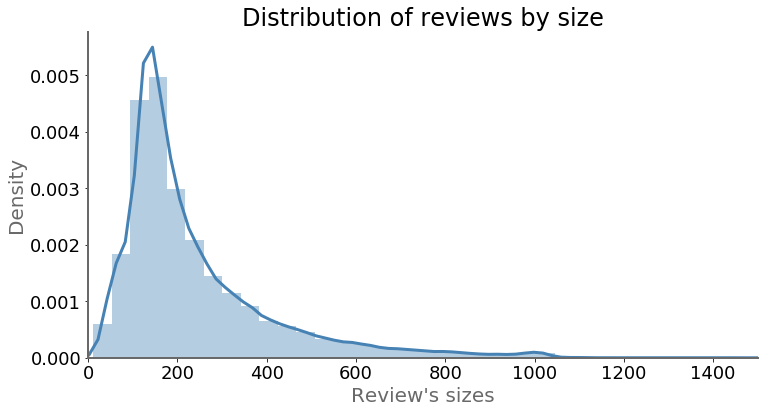

In [6]:
plt.figure(figsize=(12, 6))
ax=sns.distplot([len(i) for i in x_train],bins=60)
ax.set_title('Distribution of reviews by size')
plt.xlabel("Review's sizes")
plt.ylabel('Density')
ax.set_xlim(0, 1500)
plt.show()

## Step 3 - Preprocess the data
In order to be processed by an NN, all entries must have the same length.  
We chose a review length of **review_len**  
We will therefore complete them with a padding (of \<pad\>\)  

In [7]:
review_len = 256

x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

print('\nReview example (x_train[12]) :\n\n',x_train[12])
print('\nIn real words :\n\n', dataset2text(x_train[12]))


Review example (x_train[12]) :

 [   1   14   22 1367   53  206  159    4  636  898   74   26   11  436
  363  108    7   14  432   14   22    9 1055   34 8599    2    5  381
 3705 4509   14  768   47  839   25  111 1517 2579 1991  438 2663  587
    4  280  725    6   58   11 2714  201    4  206   16  702    5 5176
   19  480 5920  157   13   64  219    4    2   11  107  665 1212   39
    4  206    4   65  410   16  565    5   24   43  343   17 5602    8
  169  101   85  206  108    8 3008   14   25  215  168   18    6 2579
 1991  438    2   11  129 1609   36   26   66  290 3303   46    5  633
  115 4363    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   

### Save dataset and dictionary (can be usefull)

In [8]:
os.makedirs('./data',   mode=0o750, exist_ok=True)

with h5py.File('./data/dataset_imdb.h5', 'w') as f:
    f.create_dataset("x_train",    data=x_train)
    f.create_dataset("y_train",    data=y_train)
    f.create_dataset("x_test",     data=x_test)
    f.create_dataset("y_test",     data=y_test)

with open('./data/word_index.json', 'w') as fp:
    json.dump(word_index, fp)

with open('./data/index_word.json', 'w') as fp:
    json.dump(index_word, fp)

print('Saved.')

Saved.


## Step 4 - Build the model
Few remarks :
1. We'll choose a dense vector size for the embedding output with **dense_vector_size**
2. **GlobalAveragePooling1D** do a pooling on the last dimension : (None, lx, ly) -> (None, ly)  
In other words: we average the set of vectors/words of a sentence
3. L'embedding de Keras fonctionne de manière supervisée. Il s'agit d'une couche de *vocab_size* neurones vers *n_neurons* permettant de maintenir une table de vecteurs (les poids constituent les vecteurs). Cette couche ne calcule pas de sortie a la façon des couches normales, mais renvois la valeur des vecteurs. n mots => n vecteurs (ensuite empilés par le pooling)  
Voir : https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

A SUIVRE : https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks
### 4.1 - Build
More documentation about :
 - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
 - [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [9]:
def get_model(dense_vector_size=128):
    
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dim    = vocab_size, 
                                     output_dim   = dense_vector_size, 
                                     input_length = review_len))
    model.add(keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(1,                 activation='sigmoid'))

    model.compile(optimizer = 'adam',
                  loss      = 'binary_crossentropy',
                  metrics   = ['accuracy'])
    return model

## Step 5 - Train the model
### 5.1 - Get it

In [15]:
model = get_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 128)          1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [16]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.1 - Train it
GPU : batch_size=512 : 305s

In [ ]:
%%time

n_epochs   = 10
batch_size = 32

history = model.fit(x_train,
                    y_train,
                    epochs          = n_epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = 1,
                    callbacks       = [savemodel_callback])


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 206s 8ms/sample - loss: 0.6684 - accuracy: 0.5654 - val_loss: 0.6667 - val_accuracy: 0.5606
Epoch 2/10
 9120/25000 [=========>....................] - ETA: 1:42 - loss: 0.6228 - accuracy: 0.5968

## Step 6 - Evaluate
### 6.1 - Training history

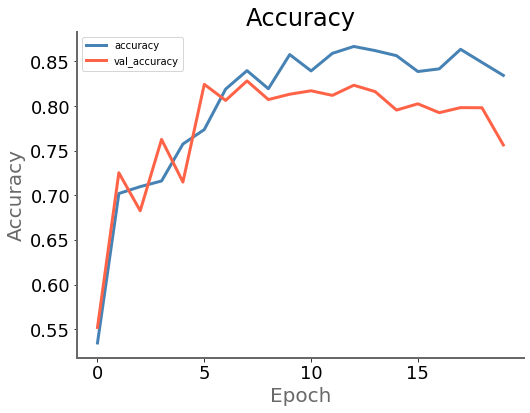

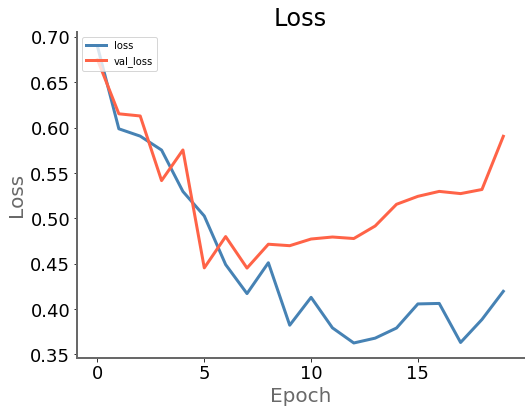

In [13]:
ooo.plot_history(history)

### 6.2 - Reload and evaluate best model

x_test / loss      : 0.4452
x_test / accuracy  : 0.8282


#### Accuracy donut is :

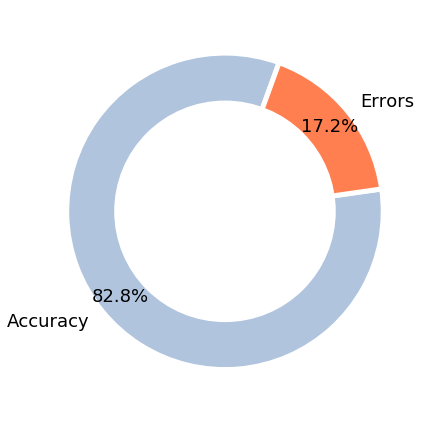

#### Confusion matrix is :

,0,1
0,0.81,0.19
1,0.15,0.85


In [14]:
model = keras.models.load_model('./run/models/best_model.h5')

# ---- Evaluate
reload(ooo)
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
ooo.plot_donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :")

# ---- Confusion matrix

y_pred   = model.predict_classes(x_test)

ooo.display_confusion_matrix(y_test,y_pred,labels=range(2),color='orange',font_size='20pt')
